## Imports

In [32]:
import wandb
import logging
from tqdm import tqdm
from wandb.sdk.wandb_run import Run
import numpy as np
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
from nn_core.common import PROJECT_ROOT
import json

## Configuration

In [33]:
from mass.utils.plots import Palette

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "axes.titlesize": 24,        # Larger axes/title fonts
        "axes.labelsize": 24,
        "xtick.labelsize": 24,
        "ytick.labelsize": 20,
        "legend.fontsize": 24,
    }
)
sns.set_context("talk")

cmap_name = "coolwarm_r"

palette = Palette(f"{PROJECT_ROOT}/misc/palette.json", map_path=f"{PROJECT_ROOT}/misc/palette_map.json")
palette

{'blue': '#335c67',
 'white': '#fff3b0',
 'yellow': '#e09f3e',
 'red': '#9e2a2b',
 'dark red': '#540b0e',
 'green': '#81b29a'}

## Get runs

In [34]:
api = wandb.Api()
entity, project = "gladia", "task-vectors-playground"  # set to your entity and project

In [35]:
def get_runs(entity, project, positive_tags, negative_tags):
    filters_pos_tags = {"$and": [{"tags": {"$eq": pos_tag}} for pos_tag in positive_tags]}
    filters_neg_tags = {}

    print(filters_pos_tags)
    filters = {**filters_pos_tags, **filters_neg_tags}
    runs = api.runs(entity + "/" + project, filters=filters)

    print(f"There are {len(runs)} runs respecting these conditions.")
    return runs

In [36]:
datasets =  ['Cars', 'DTD', 'EuroSAT', 'GTSRB', 'MNIST', 'RESISC45', 'SUN397', 'SVHN', 'CIFAR100', 'STL10', 'Flowers102', 'OxfordIIITPet', 'PCAM', 'FER2013', 'EMNIST', 'CIFAR10', 'Food101', 'FashionMNIST', 'RenderedSST2', 'KMNIST']

## Sweeping over Top-K 

In [37]:
runs = get_runs(entity, project, positive_tags=['sweep_over_topk'], negative_tags=[])

{'$and': [{'tags': {'$eq': 'sweep_over_topk'}}]}
There are 10 runs respecting these conditions.


In [38]:
topk_results = {}

for run in runs:

    col_name = f"normalized_acc/test/avg"
    norm_acc = run.history(keys=[col_name]).iloc[-1][col_name]

    top_k = run.config['nn/module/router/max_num_tasks_to_select']

    topk_results[top_k] = topk_results[top_k] = norm_acc

In [39]:
topk_results

{16: 0.9582511931657791,
 14: 0.9582490980625152,
 12: 0.9582490980625152,
 10: 0.9583146959543228,
 8: 0.9583136886358261,
 6: 0.9581779211759567,
 4: 0.9582511931657791,
 3: 0.9581855952739715,
 2: 0.958938479423523,
 1: 0.9442167475819587}

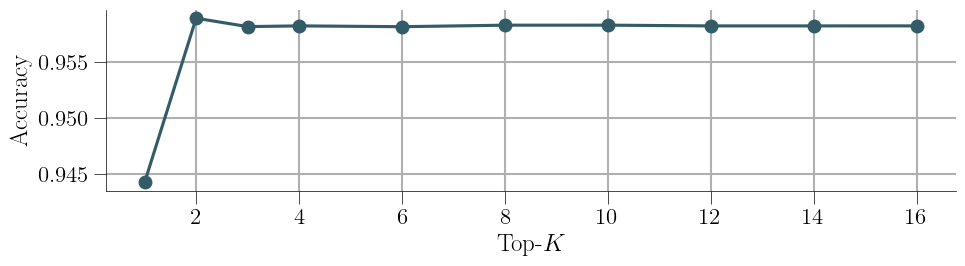

In [40]:
x_labels = topk_results.keys()
y_labels = topk_results.values()

plt.figure(figsize=(10, 3))
plt.plot(x_labels, y_labels, marker='o', color=palette["blue"], label="Top-K Accuracy")
plt.xlabel("Top-$K$")
plt.ylabel("Accuracy")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().xaxis.set_tick_params(width=0.5)
plt.gca().yaxis.set_tick_params(width=0.5)
plt.grid()
plt.tight_layout()


### Sweeping over routing threshold

In [41]:
runs = get_runs(entity, project, positive_tags=['sweep_over_threshold'], negative_tags=[])

{'$and': [{'tags': {'$eq': 'sweep_over_threshold'}}]}
There are 11 runs respecting these conditions.


In [42]:
run_by_model = {}

threshold_results = {}

for run in tqdm(runs):

    try:
        col_name = f"normalized_acc/test/avg"
        norm_acc = run.history(keys=[col_name]).iloc[-1][col_name]

        top_k = run.config['nn/module/router/threshold']

        threshold_results[top_k] = norm_acc
    
    except:
        print(f"Run {run.id} does not have the expected column {col_name}.")
        continue

  9%|▉         | 1/11 [00:00<00:02,  4.57it/s]

Run 3qx1y7cd does not have the expected column normalized_acc/test/avg.


100%|██████████| 11/11 [00:04<00:00,  2.74it/s]


In [43]:
print(threshold_results)

{0.05: 0.8973067853599787, 0.9: 0.9461365953087807, 0.8: 0.9461365953087807, 0.7: 0.9461365953087807, 0.6: 0.9461365953087807, 0.5: 0.9461365953087807, 0.4: 0.9460679784417152, 0.3: 0.9466387696564198, 0.2: 0.9581855952739715, 0.1: 0.9469290804117918}


In [44]:
x_labels = threshold_results.keys()
y_labels = threshold_results.values()

In [45]:
x_labels

dict_keys([0.05, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])

In [46]:
sorted_indices = np.argsort(list(x_labels))
x_labels = [list(x_labels)[i] for i in sorted_indices]
y_labels = [list(y_labels)[i] for i in sorted_indices]

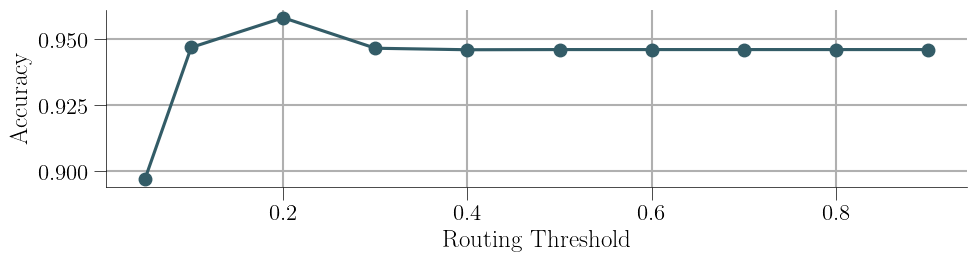

In [47]:
plt.figure(figsize=(10, 3))
plt.plot(x_labels, y_labels, marker='o', color=palette["blue"], label="Top-K Accuracy")

plt.xlabel("Routing Threshold")
plt.ylabel("Accuracy")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().xaxis.set_tick_params(width=0.5)
plt.gca().yaxis.set_tick_params(width=0.5)
plt.grid()
plt.tight_layout()
plt.show()

### Sweeping over similarity threshold

In [48]:
runs = get_runs(entity, project, positive_tags=['sweep_over_sim_threshold'], negative_tags=[])

{'$and': [{'tags': {'$eq': 'sweep_over_sim_threshold'}}]}
There are 9 runs respecting these conditions.


In [49]:
run_by_model = {}

sim_results = {}

for run in tqdm(runs):

    try:
        col_name = f"normalized_acc/test/avg"
        norm_acc = run.history(keys=[col_name]).iloc[-1][col_name]

        top_k = run.config['similarity_threshold']

        sim_results[top_k] = norm_acc
    
    except:
        print(f"Run {run.id} does not have the expected column {col_name}.")
        continue

100%|██████████| 9/9 [00:03<00:00,  2.27it/s]


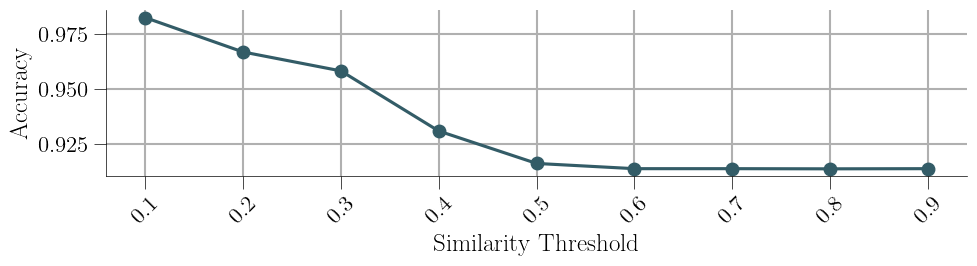

In [50]:
plt.figure(figsize=(10, 3))
plt.plot(sim_results.keys(), sim_results.values(), marker='o', color=palette["blue"], label="Top-K Accuracy")
plt.xlabel("Similarity Threshold")
plt.ylabel("Accuracy")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().xaxis.set_tick_params(width=0.5)
plt.gca().yaxis.set_tick_params(width=0.5)
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
